In [22]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import  mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import logging
import itertools
import warnings
warnings.filterwarnings('ignore')

In [55]:
df_monthly = pd.read_csv('../Data/df_monthly.csv')
df_monthly.drop(columns=['Unnamed: 0'], inplace=True)
df_yearly = pd.read_csv('../Data/df_yearly.csv')
df_yearly.drop(columns=['Unnamed: 0'], inplace=True)
df_yearly['ds'] = pd.to_datetime(df_yearly['ds'])

In [116]:
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
    """
    computes common regression metrics (mae, mape, r2) between true and predicted values.

    parameters:
    y_true (np.ndarray): array of true values.
    y_pred (np.ndarray): array of predicted values.

    returns:
    tuple: mae, mape, and r2 score.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mape, r2

def tune_prophet_model(df_monthly: pd.DataFrame, freq: str) -> pd.DataFrame:
    """
    tunes the Prophet model hyperparameters.

    parameters:
    df_monthly (pd.DataFrame): dataframe containing the monthly time series data.
    freq (str): frequency of the time series data.

    returns:
    pd.DataFrame: dataframe containing the results of the grid search.
    """
    results = []
    cap_value = df_monthly['y'].max() * 1.1  # 10% higher than max value

    # define parameter grid
    growth_options = ['linear']
    n_changepoints_options = [10]
    changepoint_prior_scale_options = [0.01]
    seasonality_periods = [6]
    seasonality_orders = [5]

    param_grid = list(itertools.product(
        growth_options,
        n_changepoints_options,
        changepoint_prior_scale_options,
        seasonality_periods,
        seasonality_orders
    ))

    # split data into train and test sets
    train = df_monthly[(df_monthly['ds'] >= '2012-01-01') & (df_monthly['ds'] <= '2017-12-31')].copy()
    test = df_monthly[(df_monthly['ds'] >= '2019-01-01') & (df_monthly['ds'] <= '2024-12-31')].copy()

    # loop over all parameter combinations
    for growth, n_changepoints, cps, period, fourier in param_grid:
        df_train = train.copy()
        if growth == 'logistic':
            df_train['cap'] = cap_value

        model = Prophet(growth=growth, n_changepoints=n_changepoints, changepoint_prior_scale=cps)
        
        # add seasonality only for monthly data
        if freq == 'M':
            model.add_seasonality(name='custom', period=period, fourier_order=fourier)

        try:
            model.fit(df_train)

            # prepare test data for prediction
            df_test_future = test[['ds']].copy()
            if growth == 'logistic':
                df_test_future['cap'] = cap_value

            forecast = model.predict(df_test_future)

            y_true = test['y'].values
            y_pred = forecast['yhat'].values

            mae, mape, r2 = compute_metrics(y_true, y_pred)

            results.append({
                'params': {
                    'growth': growth,
                    'n_changepoints': n_changepoints,
                    'changepoint_prior_scale': cps,
                    'period': period,
                    'fourier_order': fourier
                },
                'mae': mae,
                'mape': mape,
                'r2': r2
            })
        except Exception as e:
            continue

    results_df = pd.DataFrame(results).sort_values(by=['mae', 'mape', 'r2'], ascending=[True, True, False])
    return results_df

def train_final_model(df: pd.DataFrame, best_params: dict, freq: str) -> tuple:
    """
    trains the final prophet model using the best parameters from the grid search 
    and returns the trained model and forecasts for 20 years or 9 months.

    parameters:
    df (pd.DataFrame): dataframe containing the monthly time series data.
    best_params (dict): dictionary containing the best parameters for the prophet model.

    returns:
    tuple: trained model and forecast dataframe.
    """
    cap_value = df['y'].max() * 1.1  # 10% higher than max value
    df_full = df.copy()
    if best_params['growth'] == 'logistic':
        df_full['cap'] = cap_value

    # create the final model with the best parameters
    model = Prophet(
        growth=best_params['growth'],
        n_changepoints=best_params['n_changepoints'],
        changepoint_prior_scale=best_params['changepoint_prior_scale']
    )
    
    # add seasonality only for monthly data
    if freq == 'M':
        model.add_seasonality(name='custom', period=best_params['period'], fourier_order=best_params['fourier_order'])

    model.fit(df_full)

    # forecast horizon logic
    forecast_horizon = 20 if freq == 'YE-DEC' else 9  # 20 years for yearly, 9 months for monthly
    future = model.make_future_dataframe(periods=forecast_horizon, freq=freq)  # Adjust forecast horizon
    if best_params['growth'] == 'logistic':
        future['cap'] = cap_value

    forecast = model.predict(future)
    return model, forecast

def plot_forecast(df: pd.DataFrame, forecast: pd.DataFrame, freq: str) -> None:
    """
    Plots the forecasted data.
    
    parameters:
    df (pd.DataFrame): dataframe containing the original data.
    forecast (pd.DataFrame): dataframe containing the forecasted data.
    freq (str): frequency of the time series data.
    """
    plt.figure(figsize=(15, 6))

    # ensure datetime format without timezone issues
    df['ds'] = pd.to_datetime(df['ds'])
    forecast['ds'] = pd.to_datetime(forecast['ds'])

    # determine the start and end dates of the training and test periods
    if freq == 'ME':
        train_start = pd.to_datetime("2012-01-31")  # start of training for monthly data
        train_end = pd.to_datetime("2017-12-31")
        test_start = pd.to_datetime("2019-01-01")
        horizon_splits = [1, 6, 9]  # 1-month, 2–6, 7–9
    elif freq == 'YE-DEC':
        train_start = pd.to_datetime("2010-01-01")  # start of training for yearly data
        train_end = pd.to_datetime("2020-12-31")
        test_start = pd.to_datetime("2021-01-01")
        horizon_splits = [1, 10, 20]  # 1-year, 2–10, 11–20
    else:
        raise ValueError(f"Unsupported frequency: {freq}")

    train = df[(df['ds'] >= train_start) & (df['ds'] <= train_end)]  # use dynamic train start date
    test = df[(df['ds'] >= test_start) & (df['ds'] <= df['ds'].max())]

    # dynamically determine the cutoff date from the last actual observation
    cutoff_date = df['ds'].max()
    forecast_period = forecast[forecast['ds'] > cutoff_date].copy()

    # plot main series
    forecast = forecast[forecast['ds'] >= train_start]
    plt.plot(train['ds'], train['y'], label='Train', color='blue')
    plt.plot(test['ds'], test['y'], label='Test', color='orange')
    plt.plot(forecast['ds'], forecast['yhat'], label='Prediction', color='black')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)

    # plot forecast horizon coloring
    horizon_len = len(forecast_period)
    if freq == 'ME' and horizon_len >= horizon_splits[-1]:
        f1 = forecast_period.iloc[0:horizon_splits[0]]
        f2 = forecast_period.iloc[horizon_splits[0]:horizon_splits[1]]
        f3 = forecast_period.iloc[horizon_splits[1]:horizon_splits[2]]

        # add the first day of the period to f1, f2, f3 for proper visualization
        f1_start = pd.DataFrame({'ds': [f1['ds'].min() - pd.Timedelta(days=30)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})
        f2_start = pd.DataFrame({'ds': [f2['ds'].min() - pd.Timedelta(days=30)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})
        f3_start = pd.DataFrame({'ds': [f3['ds'].min() - pd.Timedelta(days=30)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})

        # append the first day of each period to f1, f2, f3
        f1 = pd.concat([f1_start, f1])
        f2 = pd.concat([f2_start, f2])
        f3 = pd.concat([f3_start, f3])

        plt.axvspan(f1['ds'].min(), f1['ds'].max(), color='green', alpha=0.3, label='1-month ahead')
        plt.axvspan(f2['ds'].min(), f2['ds'].max(), color='yellow', alpha=0.3, label='2–6 months ahead')
        plt.axvspan(f3['ds'].min(), f3['ds'].max(), color='red', alpha=0.3, label='7–9 months ahead')

    elif freq == 'YE-DEC' and horizon_len >= horizon_splits[-1]:
        f1 = forecast_period.iloc[0:horizon_splits[0]]
        f2 = forecast_period.iloc[horizon_splits[0]:horizon_splits[1]]
        f3 = forecast_period.iloc[horizon_splits[1]:horizon_splits[2]]

        # add the first day of the period to f1, f2, f3 for proper visualization
        f1_start = pd.DataFrame({'ds': [f1['ds'].min() - pd.Timedelta(days=365)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})
        f2_start = pd.DataFrame({'ds': [f2['ds'].min() - pd.Timedelta(days=365)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})
        f3_start = pd.DataFrame({'ds': [f3['ds'].min() - pd.Timedelta(days=365)], 'yhat': [None], 'yhat_lower': [None], 'yhat_upper': [None]})

        # append the first day of each period to f1, f2, f3
        f1 = pd.concat([f1_start, f1])
        f2 = pd.concat([f2_start, f2])
        f3 = pd.concat([f3_start, f3])

        plt.axvspan(f1['ds'].min(), f1['ds'].max(), color='green', alpha=0.3, label='1-year ahead')
        plt.axvspan(f2['ds'].min(), f2['ds'].max(), color='yellow', alpha=0.3, label='2–10 years ahead')
        plt.axvspan(f3['ds'].min(), f3['ds'].max(), color='red', alpha=0.3, label='11–20 years ahead')
    else:
        print(f"Warning: not enough forecasted points to color the horizon (found {horizon_len})")

    plt.legend()
    plt.title('Forecast with Prophet')
    plt.xlabel('Date')
    plt.ylabel('y')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def run_pipeline(df: pd.DataFrame) -> tuple:
    """
    runs the full pipeline: tune model, train final model, and plot forecast.

    parameters:
    df_monthly (pd.DataFrame): dataframe containing the monthly time series data.

    returns:
    tuple: the results of the grid search and the final forecast dataframe.
    """
    freq = pd.infer_freq(df['ds'].sort_values())
    # print(f"Detected frequency: {freq}")

    results_df = tune_prophet_model(df, freq)
    best_params = results_df.iloc[0]['params']
    model, forecast = train_final_model(df, best_params, freq)
    plot_forecast(df, forecast, freq)
    return results_df, model, forecast

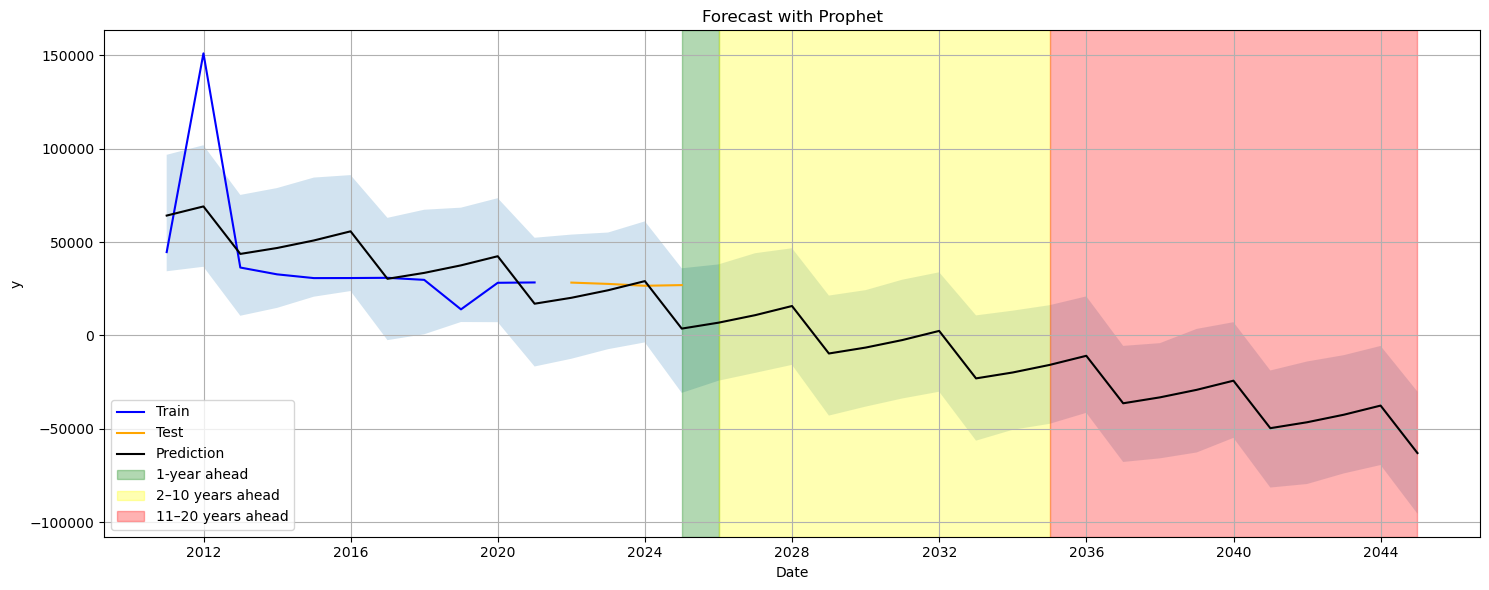

In [117]:
results_df, model, forecast = run_pipeline(df_yearly)

In [112]:
results_df

,params,mae,mape,r2
0,"{'growth': 'linear', 'n_changepoints': 10, 'ch...",3077.122759,0.112175,-22.399871


# OLD CODE